In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
from tqdm import tqdm  

ImportError: /dartfs-hpc/rc/home/k/f006fpk/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/h5py/defs.cpython-39-x86_64-linux-gnu.so: undefined symbol: H5Pget_fapl_direct

In [2]:
import matplotlib.pyplot as plt
import cell2location
from cell2location.models import Cell2location, RegressionModel
from cell2location.plt import plot_spatial
from cell2location.utils import select_slide
from cell2location.utils.filtering import filter_genes

ImportError: /dartfs-hpc/rc/home/k/f006fpk/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/h5py/defs.cpython-39-x86_64-linux-gnu.so: undefined symbol: H5Pget_fapl_direct

In [3]:
import scvi 
import os

In [4]:
!nvidia-smi

Fri Feb 16 13:48:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB            Off| 00000000:18:00.0 Off |                    0 |
| N/A   36C    P0               53W / 300W|   8127MiB / 32768MiB |      5%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,3"

In [5]:
sc_adata_1 = sc.read_h5ad("./labeled_data/SP18_16438_A3_cell_labels.h5ad")
sc_adata_1.var_names_make_unique()
sc_adata_2 = sc.read_h5ad("./labeled_data/SP18_56_A19_cell_labels.h5ad")
sc_adata_2.var_names_make_unique()

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
sc_adata_1.obs["batch"] = "SP18_16438_A3"
sc_adata_2.obs["batch"] = "SP18_56_A19"

In [7]:
sc_adata = sc.concat([sc_adata_1, sc_adata_2], join='outer')

In [17]:
visium_adata = sc.read_h5ad('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/gene_selection/all_genes_filtered_raw/data/adatas/83-3_0_adata.h5ad')

In [18]:
# visium_adata = sc.read_h5ad("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/gene_selection/all_genes_filtered/data/adatas/97_A7-81_A11_0_adata.h5ad")

In [19]:
visium_adata.var_names_make_unique()
sc_adata.var_names_make_unique()

In [20]:
visium_adata, sc_adata

(AnnData object with n_obs × n_vars = 5571 × 17796
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 20941 × 16678
     obs: 'cell_type', 'batch', 'n_genes'
     var: 'n_cells', 'MT_gene'
     obsm: 'MT')

In [21]:
def standard_scanpy_filtering(adata, min_genes=200, min_cells=3, target_sum=1e4, log_transform=True, find_variable_genes=True):
    """
    Applies a standard filtering workflow to an AnnData object.

    Parameters:
    - adata: The AnnData object containing the data.
    - min_genes: Minimum number of genes expressed for a cell to be kept.
    - min_cells: Minimum number of cells a gene must be expressed in to be kept.
    - target_sum: The target total counts per cell after normalization.
    - log_transform: If True, log-transform the data after normalization.
    - find_variable_genes: If True, identify highly variable genes after preprocessing.

    Returns:
    - Updates the input AnnData object in place with filtered, normalized, and optionally log-transformed data.
    - If find_variable_genes is True, also updates adata.var with 'highly_variable' boolean column.
    """
    # Filter cells with too few genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    
    # Filter genes expressed in too few cells
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    # find mitochondria-encoded (MT) genes
    adata.var['MT_gene'] = [gene.startswith('MT-') for gene in adata.var.index]

    # remove MT genes for spatial mapping (keeping their counts in the object)
    adata.obsm['MT'] = adata[:, adata.var['MT_gene'].values].X.toarray()
    adata = adata[:, ~adata.var['MT_gene'].values]
    return adata 


In [22]:
#filter out 
# visium_adata = standard_scanpy_filtering(visium_adata)
sc_adata = standard_scanpy_filtering(sc_adata)

In [23]:
visium_adata.shape, sc_adata.shape

((5571, 17796), (20939, 16678))

In [24]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_adata.var_names, sc_adata.var_names)

visium_adata = visium_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

In [25]:
sc_adata, visium_adata

(AnnData object with n_obs × n_vars = 20939 × 16678
     obs: 'cell_type', 'batch', 'n_genes'
     var: 'n_cells', 'MT_gene'
     obsm: 'MT',
 AnnData object with n_obs × n_vars = 5571 × 16678
     obs: 'in_tissue', 'array_row', 'array_col'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial')

In [26]:
# prepare anndata for the regression model
RegressionModel.setup_anndata(
    adata=sc_adata,
    # # 10X reaction / sample / batch
    batch_key="batch",
    
    # cell type, covariate used for constructing signatures
    labels_key="cell_type",
)
mod = RegressionModel(sc_adata)
mod.view_anndata_setup()

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(
    max_epochs=250,
    batch_size=2500,
    train_size=1,
    lr=0.002,
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 20939 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   7   │
│          n_vars          │ 16678 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │ SP18_16438_A3 │          0          │
│                    │  SP18_56_A19  │          1          │
└────────────────────┴───────────────┴─────────────────────┘

                    labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │     B      │          0          │
│                        │    Epi     │          1          │
│                        │    Mast    │          2          │
│                        │  Myeloid   │          3          │
│                        │   Plasma   │          4          │
│                        │   Strom    │          5          │
│                        │   TNKILC   │          6          │
└────────────────────────┴────────────┴─────────────────────┘

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
/dartfs/rc/n

Epoch 250/250: 100%|███████████████████████████████████████████████████████| 250/250 [08:49<00:00,  2.49s/it, v_num=1, elbo_train=7.96e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|███████████████████████████████████████████████████████| 250/250 [08:49<00:00,  2.12s/it, v_num=1, elbo_train=7.96e+7]


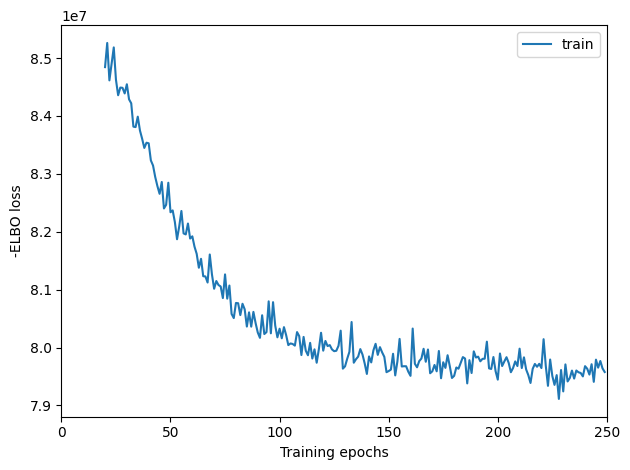

In [27]:
mod.plot_history(20)

In [28]:
sc_adata = mod.export_posterior(
    sc_adata,
    sample_kwargs={"num_samples": 1000, "batch_size": 2500, "use_gpu": True},
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████| 999/999 [00:09<00:00, 101.03it/s]


In [29]:
# export estimated expression in each cluster
if "means_per_cluster_mu_fg" in sc_adata.varm.keys():
    inf_aver = sc_adata.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in sc_adata.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = sc_adata.var[
        [f"means_per_cluster_mu_fg_{i}" for i in sc_adata.uns["mod"]["factor_names"]]
    ].copy()
inf_aver.columns = sc_adata.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

B       Epi      Mast   Myeloid    Plasma
A1CF     0.000374  0.171872  0.007818  0.001786  0.001073
A2M      0.011801  0.059298  0.065469  0.625358  0.022455
A3GALT2  0.000496  0.000778  0.004380  0.005935  0.001009
A4GALT   0.069785  0.004327  0.010696  0.015203  0.003141
A4GNT    0.000407  0.000795  0.005265  0.000941  0.000810

In [30]:
inf_aver

B       Epi      Mast   Myeloid    Plasma     Strom    TNKILC
A1CF     0.000374  0.171872  0.007818  0.001786  0.001073  0.009416  0.000772
A2M      0.011801  0.059298  0.065469  0.625358  0.022455  2.527498  0.004350
A3GALT2  0.000496  0.000778  0.004380  0.005935  0.001009  0.005285  0.000385
A4GALT   0.069785  0.004327  0.010696  0.015203  0.003141  0.295060  0.003157
A4GNT    0.000407  0.000795  0.005265  0.000941  0.000810  0.000399  0.000277
...           ...       ...       ...       ...       ...       ...       ...
ZXDC     0.115329  0.171550  0.068111  0.126992  0.060470  0.113927  0.071290
ZYG11A   0.009964  0.001053  0.004385  0.000583  0.024764  0.001104  0.000337
ZYG11B   0.060151  0.143109  0.100454  0.091767  0.059024  0.134327  0.033680
ZYX      0.226284  0.810570  0.321882  0.968318  0.183654  1.373927  0.239472
ZZEF1    0.222828  0.443048  0.070013  0.241672  0.209641  0.218010  0.164276

[16678 rows x 7 columns]

In [31]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_adata.var_names, inf_aver.index)
visium_adata = visium_adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [32]:
visium_adata.X.todense()

matrix([[ 1.,  0.,  0., ...,  1., 21.,  1.],
        [ 0.,  4.,  0., ...,  0.,  5.,  0.],
        [ 2.,  2.,  0., ...,  2.,  9.,  4.],
        ...,
        [ 0.,  2.,  1., ...,  0.,  1.,  1.],
        [ 0., 12.,  0., ...,  0., 13.,  0.],
        [ 1.,  6.,  0., ...,  3., 11.,  0.]], dtype=float32)

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 5571  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 16678 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
/dartfs/rc/n

Epoch 10000/10000: 100%|███████████████████████████████████████████████| 10000/10000 [30:08<00:00,  5.45it/s, v_num=1, elbo_train=8.34e+7]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 10000/10000: 100%|███████████████████████████████████████████████| 10000/10000 [30:08<00:00,  5.53it/s, v_num=1, elbo_train=8.34e+7]


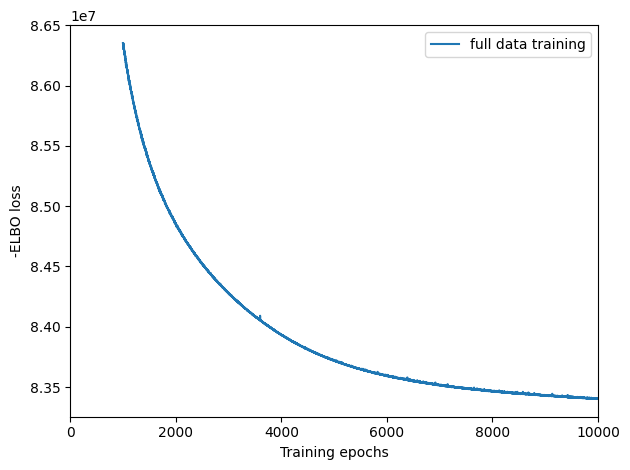

In [33]:
Cell2location.setup_anndata(adata=visium_adata)

mod = Cell2location(
    visium_adata,
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200,
)
mod.view_anndata_setup()

mod.train(
    max_epochs=10000,
    # train using full data (batch_size=None)
    batch_size=None,
    # use all data points in training because
    # we need to estimate cell abundance at all locations
    train_size=1,
)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=["full data training"]);

In [34]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
visium_adata = mod.export_posterior(
    visium_adata,
    sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs, "use_gpu": True},
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████| 999/999 [00:23<00:00, 42.42it/s]


In [35]:
visium_adata.obsm["q05_cell_abundance_w_sf"]

q05cell_abundance_w_sf_B  q05cell_abundance_w_sf_Epi  \
AACACCAGCCTACTCG-1                  0.225729                   45.810612   
AACACCATACGATAGT-1                  0.255919                    0.022906   
AACACCGAATGTCTCA-1                  1.426119                   45.196504   
AACACCTAAGCATTGC-1                  0.149490                   17.426737   
AACACTCGTTGTGACG-1                  0.262026                   19.046391   
...                                      ...                         ...   
TGTTGCGTATGTATTA-1                  0.452933                    0.021688   
TGTTGGAAGCTACAAT-1                  0.084238                    0.006120   
TGTTGGCCTGTAGCGG-1                  0.119085                    5.165085   
TGTTGGTGCGCACGAG-1                  0.116305                    8.193772   
TGTTGGTGCGCTTCGC-1                  1.180475                   43.483391   

                    q05cell_abundance_w_sf_Mast  \
AACACCAGCCTACTCG-1                     2.407688   
AACACCATACGATAGT-1                     0.031697   
AACACCGAATGTCTCA-1                     4.477255   
AACACCTAAGCATTGC-1                     0.670101   
AACACTCGTTGTGACG-1                     2.841896   
...                                         ...   
TGTTGCGTATGTATTA-1                     0.042181   
TGTTGGAAGCTACAAT-1                     0.021178   
TGTTGGCCTGTAGCGG-1                     0.160910   
TGTTGGTGCGCACGAG-1                     0.268827   
TGTTGGTGCGCTTCGC-1                     6.307892   

                    q05cell_abundance_w_sf_Myeloid  \
AACACCAGCCTACTCG-1                        1.921419   
AACACCATACGATAGT-1                        0.185067   
AACACCGAATGTCTCA-1                        3.085857   
AACACCTAAGCATTGC-1                        0.114183   
AACACTCGTTGTGACG-1                        0.234006   
...                                            ...   
TGTTGCGTATGTATTA-1                        0.506503   
TGTTGGAAGCTACAAT-1                        2.550376   
TGTTGGCCTGTAGCGG-1                        1.448536   
TGTTGGTGCGCACGAG-1                        8.683800   
TGTTGGTGCGCTTCGC-1                        1.113099   

                    q05cell_abundance_w_sf_Plasma  \
AACACCAGCCTACTCG-1                       0.292703   
AACACCATACGATAGT-1                       0.193202   
AACACCGAATGTCTCA-1                       0.227721   
AACACCTAAGCATTGC-1                       0.049414   
AACACTCGTTGTGACG-1                       0.095849   
...                                           ...   
TGTTGCGTATGTATTA-1                       0.726493   
TGTTGGAAGCTACAAT-1                       1.277181   
TGTTGGCCTGTAGCGG-1                       0.142038   
TGTTGGTGCGCACGAG-1                       0.259340   
TGTTGGTGCGCTTCGC-1                       0.198421   

                    q05cell_abundance_w_sf_Strom  \
AACACCAGCCTACTCG-1                      0.480188   
AACACCATACGATAGT-1                      2.079730   
AACACCGAATGTCTCA-1                      0.789871   
AACACCTAAGCATTGC-1                      0.017452   
AACACTCGTTGTGACG-1                      0.504972   
...                                          ...   
TGTTGCGTATGTATTA-1                      1.895602   
TGTTGGAAGCTACAAT-1                      3.762555   
TGTTGGCCTGTAGCGG-1                      1.234110   
TGTTGGTGCGCACGAG-1                      2.762132   
TGTTGGTGCGCTTCGC-1                      0.684587   

                    q05cell_abundance_w_sf_TNKILC  
AACACCAGCCTACTCG-1                       0.133224  
AACACCATACGATAGT-1                       0.501478  
AACACCGAATGTCTCA-1                       1.297622  
AACACCTAAGCATTGC-1                       0.137255  
AACACTCGTTGTGACG-1                       0.273006  
...                                           ...  
TGTTGCGTATGTATTA-1                       0.934137  
TGTTGGAAGCTACAAT-1                       1.542906  
TGTTGGCCTGTAGCGG-1                       0.183581  
TGTTGGTGCGCACGAG-1                       0.713048  
TGTTGGTGCGC

In [36]:
visium_adata.obs[visium_adata.uns["mod"]["factor_names"]] = visium_adata.obsm[
    "q05_cell_abundance_w_sf"
]

In [37]:
# visium_adata.obsm["spatial"] = visium_adata.obsm["spatial"].astype(float)

In [82]:
visium_adata = sc.read_h5ad('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/spot_deconvolution/mapped_visium_data/40_B10-18_G4_1_adata.h5ad')

In [83]:
visium_adata.obs

in_tissue array_row array_col  _indices  _scvi_batch  \
AACAATCCGAGTGGAC-1         1       103        47         0            0   
AACAATGTGCTCCGAG-1         1        98       158         1            0   
AACACGACAACGGAGT-1         1        71       203         2            0   
AACACGACAATTGTTC-1         1       123        13         3            0   
AACACGGAACGAGTTA-1         1        97         9         4            0   
...                      ...       ...       ...       ...          ...   
TGTTGGATAGATCAGA-1         1        86       176      7212            0   
TGTTGGCCGGATTGGT-1         1       127       189      7213            0   
TGTTGGTGATTAGGTA-1         1       108        22      7214            0   
TGTTGGTGCGGAATCA-1         1        83        87      7215            0   
TGTTGGTGGACTCAGG-1         1        86       106      7216            0   

                    _scvi_labels         B        Epi       Mast    Myeloid  \
AACAATCCGAGTGGAC-1             0  3.479613  15.341292   7.339719   5.092717   
AACAATGTGCTCCGAG-1             0  0.081343   0.347432   0.064374   0.209275   
AACACGACAACGGAGT-1             0  0.183473   0.002253   0.009518   0.006915   
AACACGACAATTGTTC-1             0  3.098774   4.840623   1.026531   5.408044   
AACACGGAACGAGTTA-1             0  2.721724  42.426446  12.082928  12.467465   
...                          ...       ...        ...        ...        ...   
TGTTGGATAGATCAGA-1             0  0.127959   0.299321   0.118564   0.046214   
TGTTGGCCGGATTGGT-1             0  0.179977   0.377140   0.024305   0.079276   
TGTTGGTGATTAGGTA-1             0  6.137301  47.028884  16.028754  15.295975   
TGTTGGTGCGGAATCA-1             0  0.672276  12.974634   5.015720   3.078667   
TGTTGGTGGACTCAGG-1             0  0.233765   0.274052   0.391702   0.316251   

                      Plasma     Strom    TNKILC  
AACAATCCGAGTGGAC-1  2.085896  7.205968  3.229224  
AACAATGTGCTCCGAG-1  0.222659  0.425055  0.046068  
AACACGACAACGGAGT-1  0.089835  2.171405  0.014183  
AACACGACAATTGTTC-1  2.377567  6.043303  3.873050  
AACACGGAACGAGTTA-1  4.531430  4.265229  3.748773  
...                      ...       ...       ...  
TGTTGGATAGATCAGA-1  0.107226  1.158004  0.021426  
TGTTGGCCGGATTGGT-1  0.028342  0.017698  0.025041  
TGTTGGTGATTAGGTA-1  5.629600  6.183317  6.552814  
TGTTGGTGCGGAATCA-1  1.186827  2.179120  1.160032  
TGTTGGTGGACTCAGG-1  0.116890  0.182286  0.164204  

[7217 rows x 13 columns]

In [84]:
colors = [
        "B",
        "Epi",
        "Mast",
        "Myeloid",
        "Plasma",
        "Strom",
        "TNKILC",
    ]

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


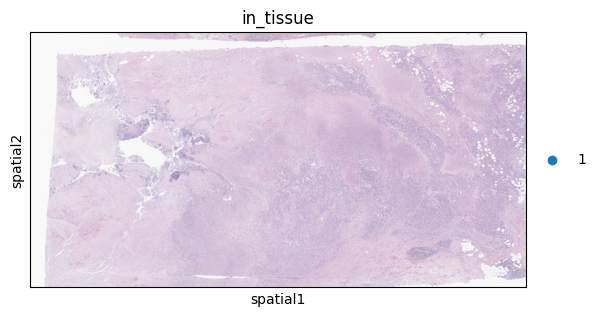

In [85]:
sc.pl.spatial(visium_adata, color = "in_tissue", alpha = 0,  img_key="hires",)

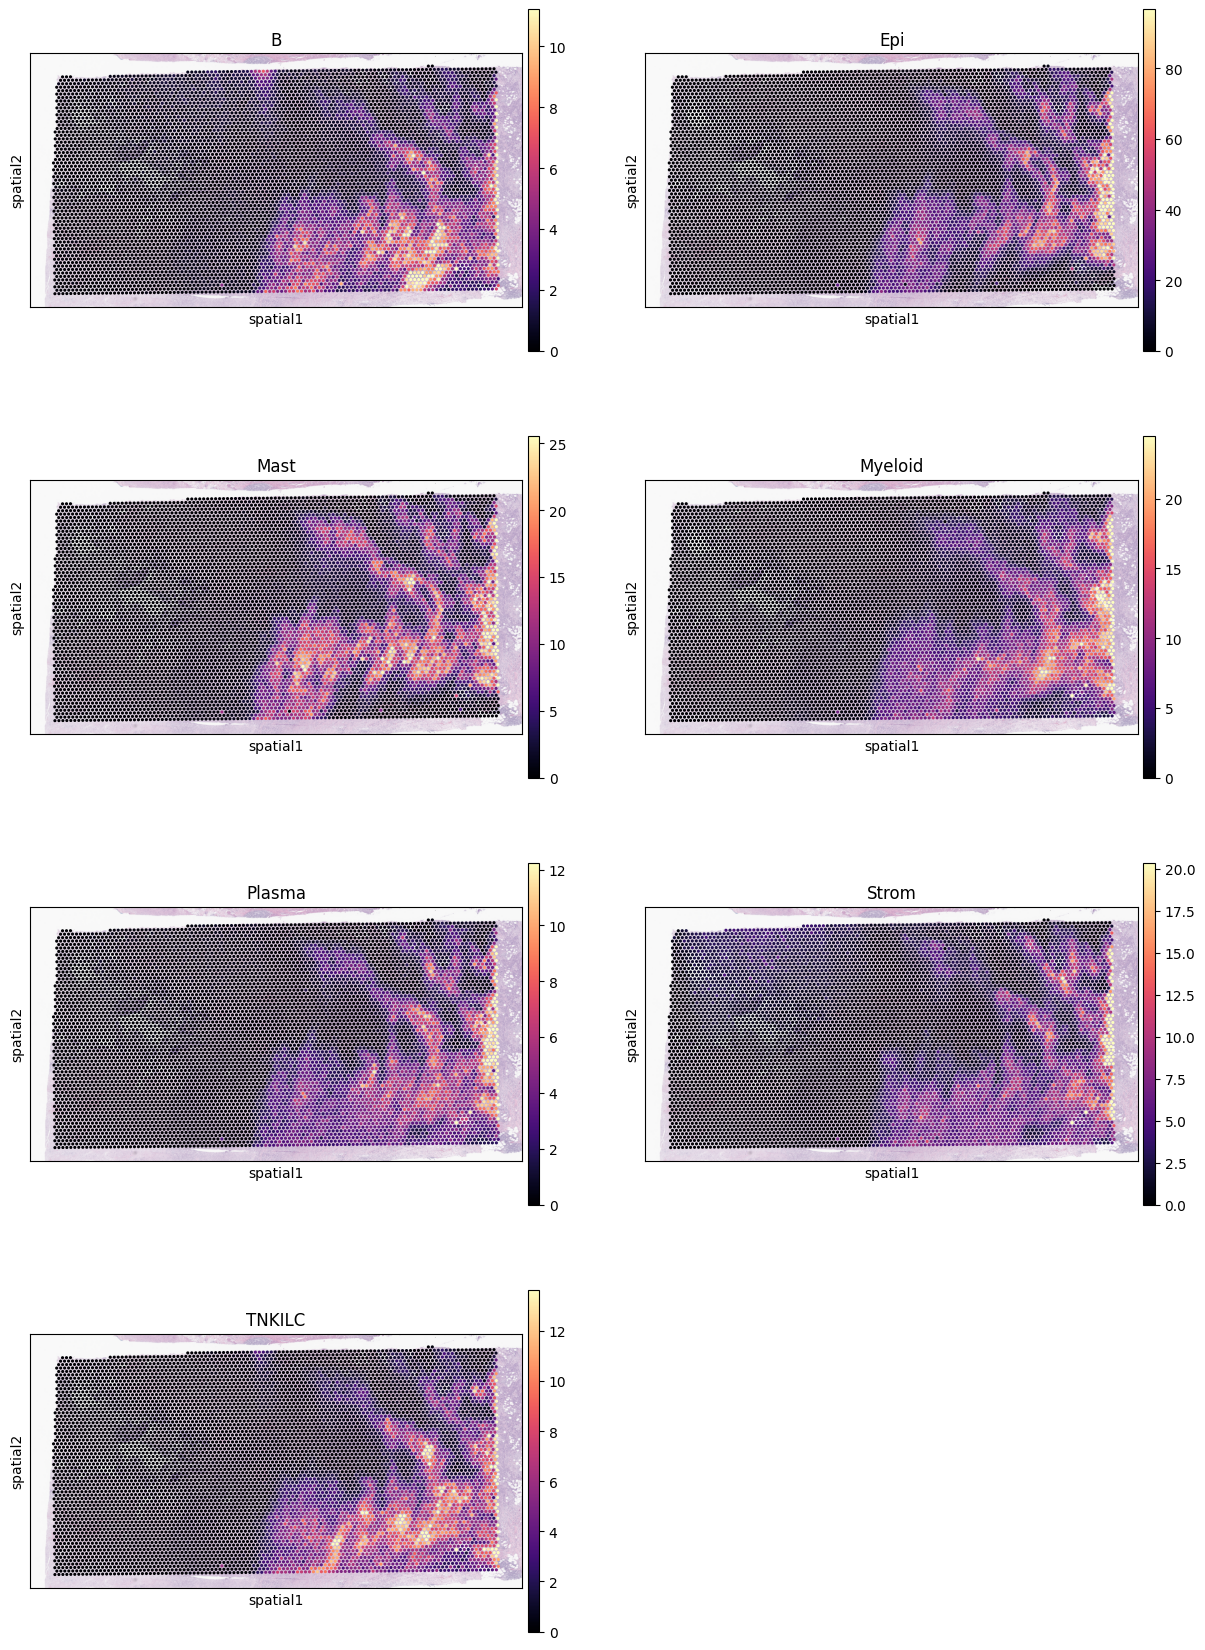

In [86]:
sc.pl.spatial(
        visium_adata,
        cmap="magma",
        # show first 8 cell types
        color=colors,
        ncols=2,
        size=1.3,
        img_key="hires",
        # limit color scale at 99.2% quantile of cell abundance
        vmin=0,
        vmax="p99.2")

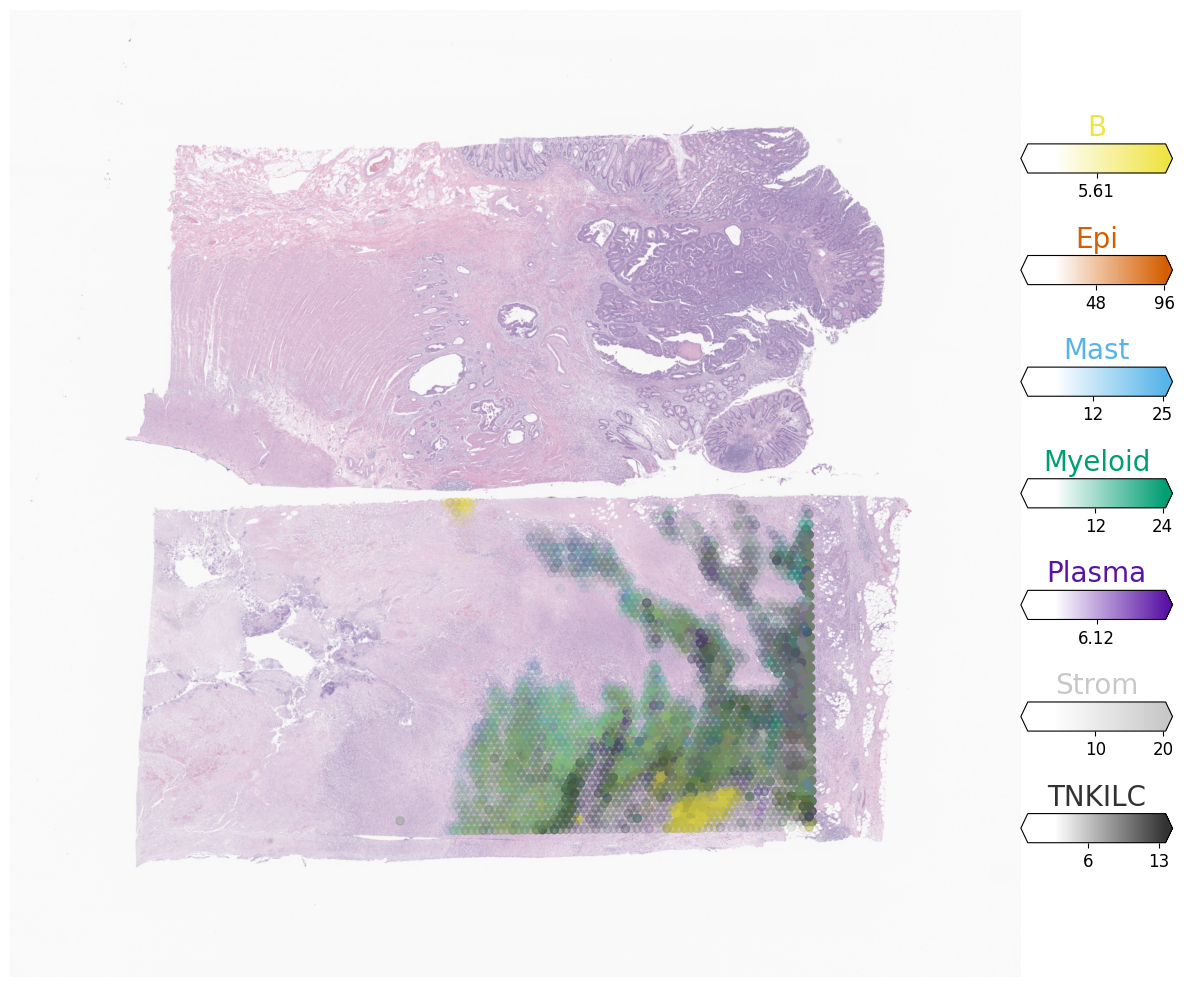

In [87]:
import matplotlib as mpl
# select up to 6 clusters
clust_labels = ["B",
        "Epi",
        "Mast",
        "Myeloid",
        "Plasma",
        "Strom",
        "TNKILC",
        ]
clust_col = [
    "" + str(i) for i in clust_labels
]  # in case column names differ from labels

# slide = select_slide(visium_adata, "V1_Human_Lymph_Node")

with mpl.rc_context({"figure.figsize": (15, 15)}):
    fig = plot_spatial(
        adata=visium_adata,
        # labels to show on a plot
        color=clust_col,
        labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style="fast",
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position="right",
    )

In [55]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(visium_adata, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(visium_adata, resolution=0.5)

# add region as categorical variable
visium_adata.obs["region_cluster"] = visium_adata.obs["leiden"].astype("category")

In [57]:
sc.tl.umap(visium_adata, min_dist = 0.3, spread = 1)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


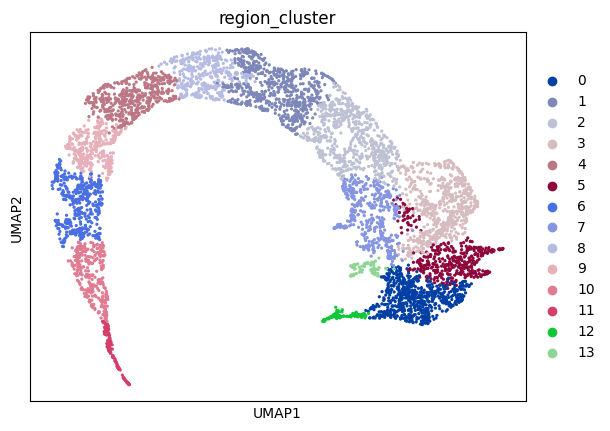

In [58]:
sc.pl.umap(visium_adata, color = "region_cluster")

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


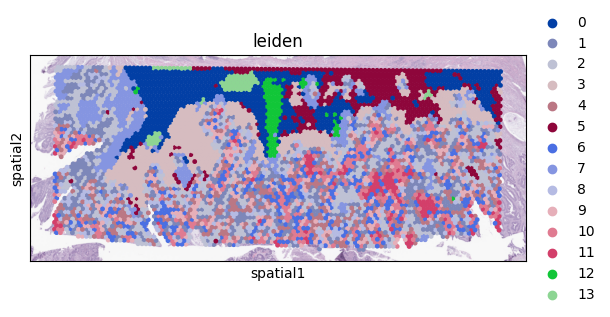

In [59]:
sc.pl.spatial(visium_adata, color = "leiden", size = 2)

In [60]:
visium_adata.write("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/spot_deconvolution/mapped_visium_data/83-3_0_adata.h5ad")

# Produce Mapping for all of the Data 

In [61]:
import scanpy as sc 
import pandas as pd 
import numpy as np 
from tqdm import tqdm  

In [62]:
import matplotlib.pyplot as plt
import cell2location
from cell2location.models import Cell2location, RegressionModel
from cell2location.plt import plot_spatial
from cell2location.utils import select_slide
from cell2location.utils.filtering import filter_genes

In [63]:
import scvi 
import os

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,3"

In [64]:
def standard_scanpy_filtering(adata, min_genes=200, min_cells=3, target_sum=1e4, log_transform=True, find_variable_genes=True):
    """
    Applies a standard filtering workflow to an AnnData object.

    Parameters:
    - adata: The AnnData object containing the data.
    - min_genes: Minimum number of genes expressed for a cell to be kept.
    - min_cells: Minimum number of cells a gene must be expressed in to be kept.
    - target_sum: The target total counts per cell after normalization.
    - log_transform: If True, log-transform the data after normalization.
    - find_variable_genes: If True, identify highly variable genes after preprocessing.

    Returns:
    - Updates the input AnnData object in place with filtered, normalized, and optionally log-transformed data.
    - If find_variable_genes is True, also updates adata.var with 'highly_variable' boolean column.
    """
    # Filter cells with too few genes
    sc.pp.filter_cells(adata, min_genes=min_genes)
    
    # Filter genes expressed in too few cells
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    # find mitochondria-encoded (MT) genes
    adata.var['MT_gene'] = [gene.startswith('MT-') for gene in adata.var.index]

    # remove MT genes for spatial mapping (keeping their counts in the object)
    adata.obsm['MT'] = adata[:, adata.var['MT_gene'].values].X.toarray()
    adata = adata[:, ~adata.var['MT_gene'].values]
    return adata 

In [67]:
# load all of the sc reference data 

sc_base_dir = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/spot_deconvolution/labeled_sc_data"

sc_datas = []

for f in os.listdir(sc_base_dir):
    sc_data = sc.read_h5ad(f"{sc_base_dir}/{f}")
    sc_data.var_names_make_unique()
    sc_data.obs["batch"] = "_".join(f.split("_")[:-2])
    sc_datas.append(sc_data)
    
sc_combined = sc.concat(sc_datas, join='outer')

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [69]:
sc_combined = standard_scanpy_filtering(sc_combined)

In [70]:
#get visium reference gene list 
visium_adata = sc.read_h5ad('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/gene_selection/all_genes_filtered_raw/data/adatas/83-3_0_adata.h5ad')
visium_adata.var_names_make_unique()

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(visium_adata.var_names, sc_combined.var_names)

visium_adata = visium_adata[:, intersect].copy()
sc_combined = sc_combined[:, intersect].copy()

In [71]:
# prepare anndata for the regression model
RegressionModel.setup_anndata(
    adata=sc_combined,
    # # 10X reaction / sample / batch
    batch_key="batch",
    
    # cell type, covariate used for constructing signatures
    labels_key="cell_type",
)
mod = RegressionModel(sc_combined)
mod.view_anndata_setup()

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(
    max_epochs=250,
    batch_size=2500,
    train_size=1,
    lr=0.002,
)

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 20941 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   7   │
│          n_vars          │ 16678 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │ SP18_16438_A3 │          0          │
│                    │  SP18_56_A19  │          1          │
└────────────────────┴───────────────┴─────────────────────┘

                    labels State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │     B      │          0          │
│                        │    Epi     │          1          │
│                        │    Mast    │          2          │
│                        │  Myeloid   │          3          │
│                        │   Plasma   │          4          │
│                        │   Strom    │          5          │
│                        │   TNKILC   │          6          │
└────────────────────────┴────────────┴─────────────────────┘

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
/dartfs/rc/n

Epoch 250/250: 100%|███████████████████████████████████████████████████████| 250/250 [06:05<00:00,  1.45s/it, v_num=1, elbo_train=7.95e+7]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|███████████████████████████████████████████████████████| 250/250 [06:05<00:00,  1.46s/it, v_num=1, elbo_train=7.95e+7]


In [72]:
sc_combined = mod.export_posterior(
    sc_combined,
    sample_kwargs={"num_samples": 1000, "batch_size": 2500, "use_gpu": True},
)

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████| 999/999 [00:09<00:00, 104.60it/s]


In [73]:
# export estimated expression in each cluster
if "means_per_cluster_mu_fg" in sc_combined.varm.keys():
    inf_aver = sc_combined.varm["means_per_cluster_mu_fg"][
        [f"means_per_cluster_mu_fg_{i}" for i in sc_combined.uns["mod"]["factor_names"]]
    ].copy()
else:
    inf_aver = sc_combined.var[
        [f"means_per_cluster_mu_fg_{i}" for i in sc_combined.uns["mod"]["factor_names"]]
    ].copy()
inf_aver.columns = sc_combined.uns["mod"]["factor_names"]
inf_aver.iloc[0:5, 0:5]

B       Epi      Mast   Myeloid    Plasma
A1CF     0.000355  0.170186  0.007712  0.001725  0.001171
A2M      0.011820  0.059357  0.065911  0.621612  0.021915
A3GALT2  0.000431  0.000802  0.003720  0.006028  0.000934
A4GALT   0.069185  0.004201  0.010097  0.015387  0.003390
A4GNT    0.000422  0.000827  0.006309  0.000813  0.000837

In [75]:
#run mapping for each Visium slide 
visium_base_dir = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/gene_selection/all_genes_filtered_raw/data/adatas"

save_dir = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Colon_ST_Training/spot_deconvolution/mapped_visium_data"

for f in tqdm(os.listdir(visium_base_dir)):
    print(f"Processing: {f}")
    visium_adata = sc.read_h5ad(f"{visium_base_dir}/{f}")
    
    # find shared genes and subset both anndata and reference signatures
    intersect = np.intersect1d(visium_adata.var_names, inf_aver.index)
    visium_adata = visium_adata[:, intersect].copy()
    inf_aver = inf_aver.loc[intersect, :].copy()
    
    Cell2location.setup_anndata(adata=visium_adata)
    mod = Cell2location(
        visium_adata,
        cell_state_df=inf_aver,
        # the expected average cell abundance: tissue-dependent
        # hyper-prior which can be estimated from paired histology:
        N_cells_per_location=30,
        # hyperparameter controlling normalisation of
        # within-experiment variation in RNA detection (using default here):
        detection_alpha=200,
    )
    mod.view_anndata_setup()

    mod.train(
        max_epochs=15000,
        # train using full data (batch_size=None)
        batch_size=None,
        # use all data points in training because
        # we need to estimate cell abundance at all locations
        train_size=1,
    )

    # # plot ELBO loss history during training, removing first 100 epochs from the plot
    # mod.plot_history(1000)
    # plt.legend(labels=["full data training"]);
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    visium_adata = mod.export_posterior(
        visium_adata,
        sample_kwargs={"num_samples": 1000, "batch_size": mod.adata.n_obs, "use_gpu": True},
    )
    
    visium_adata.obs[visium_adata.uns["mod"]["factor_names"]] = visium_adata.obsm[
    "q05_cell_abundance_w_sf"
    ]
    
    visium_adata.write(f"{save_dir}/{f}")
    

  0%|                                                                                                              | 0/23 [00:00<?, ?it/s]

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 7217  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 16678 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/u ...
/dartfs/rc/n

Epoch 944/10000:   9%|████▊                                              | 943/10000 [02:55<24:57,  6.05it/s, v_num=1, elbo_train=7.38e+7]

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: Detected KeyboardInterrupt, attempting graceful shutdown...
/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling local variables, batch:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                              | 0/23 [02:57<?, ?it/s]


KeyboardInterrupt: 

## QC Mappings

In [15]:
adata = sc.read_h5ad("./mapped_visium_data/97_A7-81_A11_0_adata.h5ad")

In [16]:
adata.obs.head()

in_tissue array_row array_col  _indices  _scvi_batch  \
AACAATGGAACCACAT-1         1        54        32         0            0   
AACACCAGCCTACTCG-1         1        31        39         1            0   
AACACCATACGATAGT-1         1         4       154         2            0   
AACACCATTCGCATAC-1         1        53       139         3            0   
AACACCGAATGTCTCA-1         1        34       176         4            0   

                    _scvi_labels         B        Epi      Mast   Myeloid  \
AACAATGGAACCACAT-1             0  0.123014   0.317627  0.050864  0.982925   
AACACCAGCCTACTCG-1             0  0.056255   0.014109  0.043059  0.073230   
AACACCATACGATAGT-1             0  0.092017  14.305948  3.918604  0.106676   
AACACCATTCGCATAC-1             0  0.045470   0.000890  0.022328  0.144784   
AACACCGAATGTCTCA-1             0  0.765517   0.000583  0.030706  0.634516   

                      Plasma      Strom    TNKILC  
AACAATGGAACCACAT-1  0.195197   1.725253  0.101366  
AACACCAGCCTACTCG-1  0.035894  15.783997  0.113649  
AACACCATACGATAGT-1  0.031806   0.092776  0.083810  
AACACCATTCGCATAC-1  0.023886  14.451832  0.092066  
AACACCGAATGTCTCA-1  1.227217  14.958064  0.821865

In [17]:
clust_labels = ["B",
        "Epi",
        "Mast",
        "Myeloid",
        "Plasma",
        "Strom",
        "TNKILC",
        ]

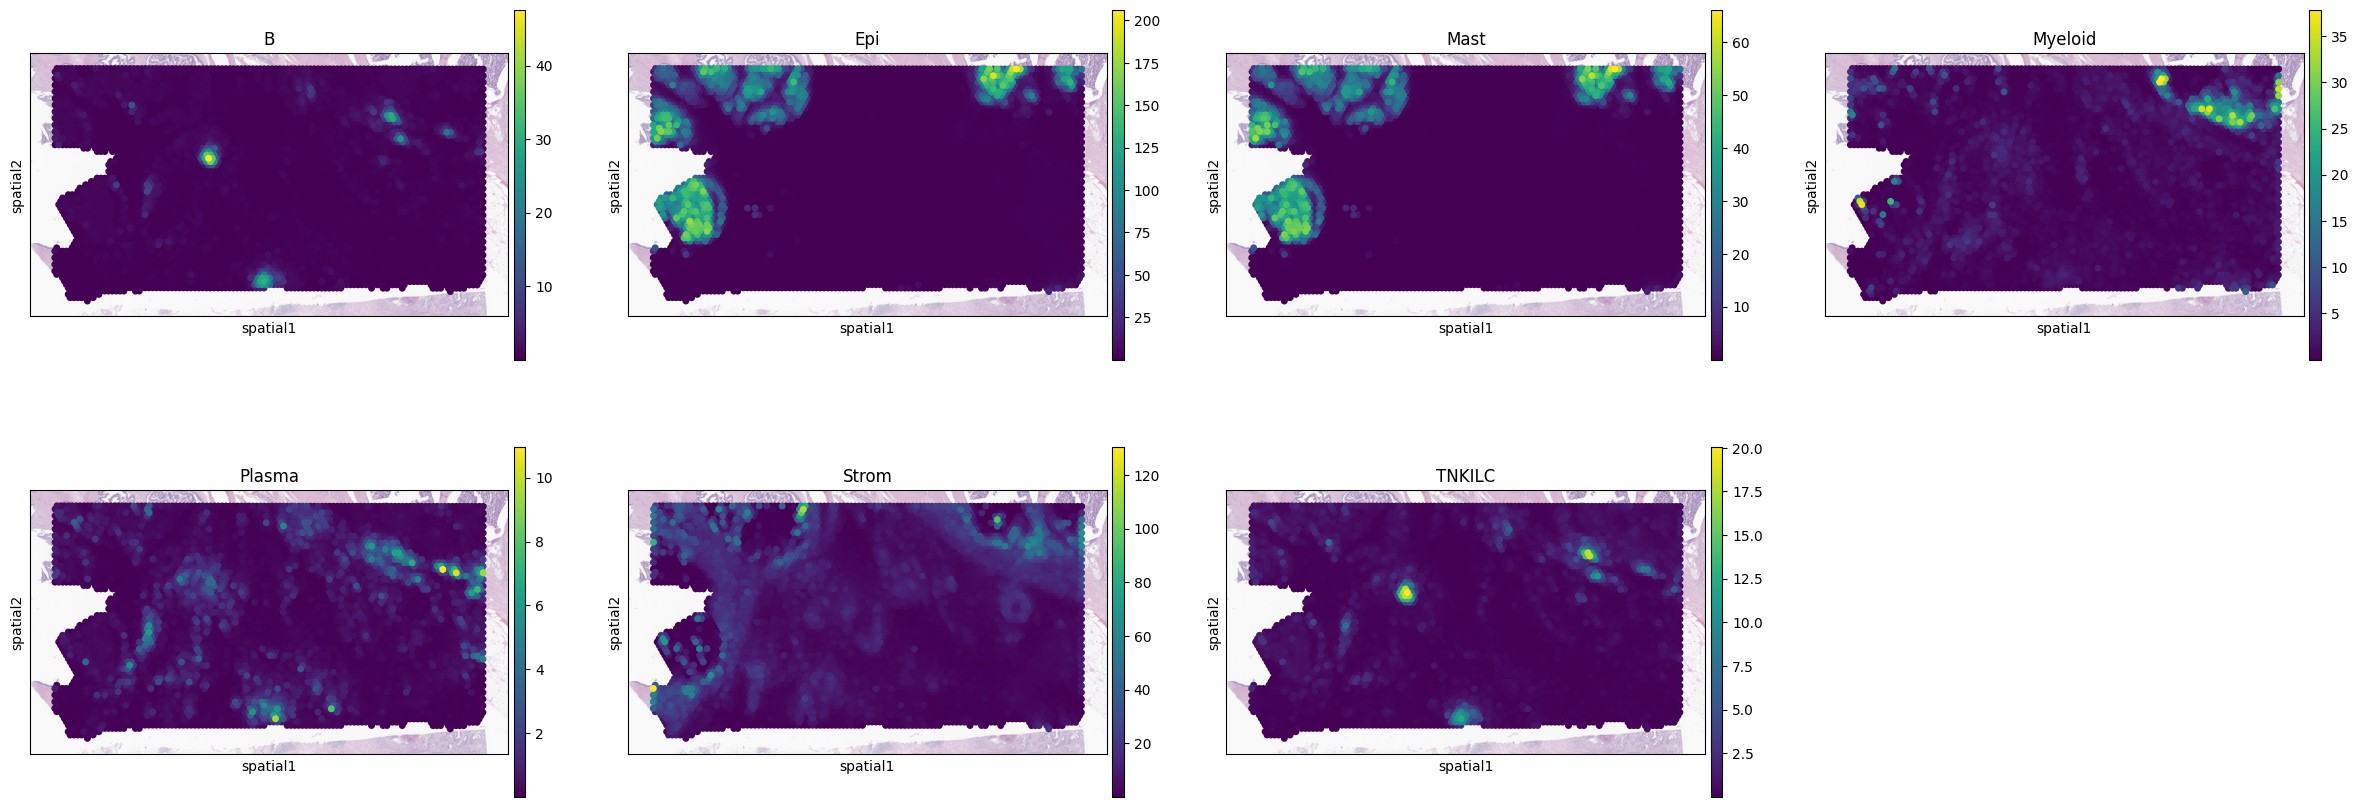

In [18]:
sc.pl.spatial(
        adata,
        color =  clust_labels, 
        alpha = 1, 
        size = 3, 
        )